This class is used to model the financial project of Wilson Lumber Company over several years. It uses sales growth, payment period & other ratios derived from Wilson's actual financials to project future financial conditions.

This is a somewhat different approach to solving this problem, nevertheless it gives some interesting information and allows for even further projections into the future, if needed.

We thought we would share this in the appendix, to demonstrate different approaches our groupmembers used.


Scenario 1: 25% growth, 55-day payment period
    sales  net_income  total_assets  bank_loan  net_worth  year
0  2500.0        45.0         820.0      189.0      289.0  1985
1  3125.0        56.0        1002.0      237.0      345.0  1986
2  3906.0        70.0        1229.0      298.0      415.0  1987
3  4883.0        87.0        1513.0      375.0      502.0  1988

Scenario 2: 25% growth, 10-day payment period
    sales  net_income  total_assets  bank_loan  net_worth  year
0  2500.0        49.0         820.0      409.0      293.0  1985
1  3125.0        62.0        1002.0      507.0      356.0  1986
2  3906.0        78.0        1229.0      630.0      434.0  1987
3  4883.0        98.0        1513.0      782.0      532.0  1988

Scenario 3: 14% growth, 10-day payment period
    sales  net_income  total_assets  bank_loan  net_worth  year
0  2500.0        49.0         820.0      409.0      293.0  1985
1  2850.0        60.0         922.0      439.0      353.0  1986
2  3249.0        71.0      

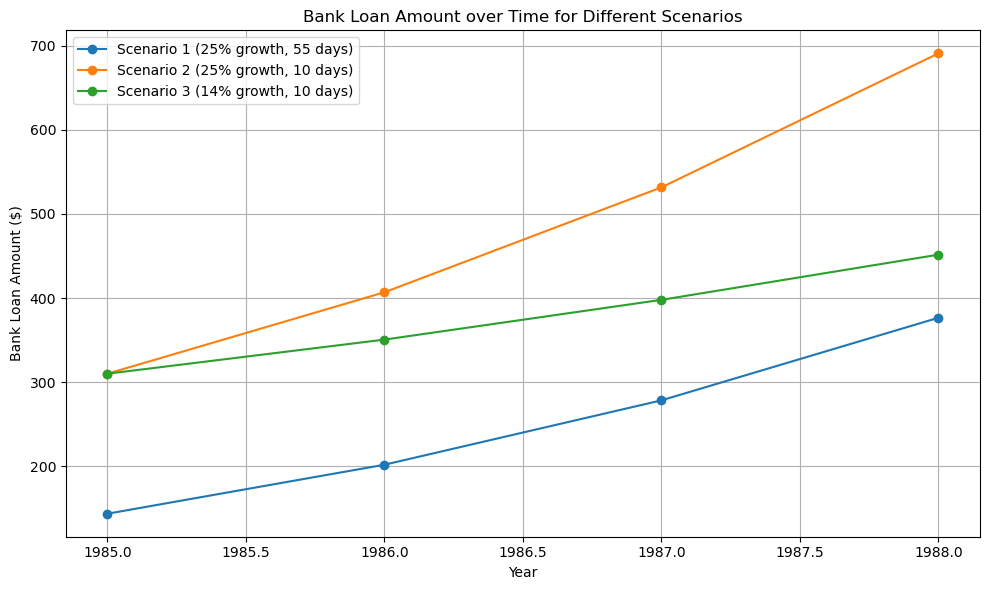

In [41]:
class WLCFinancialModel:
    def __init__(self, initial_sales, growth_rate, payment_days, years, initial_bank_loan=173000):
        # takes initial sales, growth rate, payment days and years as inputs
        # sets fixed values for net worth, bank loan & other financial ratios (since I dont have much experience doing a pro forma, I just assumed it is okay to take historical averages)
        self.initial_sales = initial_sales
        self.growth_rate = growth_rate
        self.payment_days = payment_days
        self.years = years
        self.interest_rate = 0.14 # interest rate as mentioned in text
        self.initial_net_worth = 244  # Net worth from 1984
        self.initial_bank_loan = initial_bank_loan  # Set initial bank loan to 173,000

        # Ratios based on 1984 data
        self.inventory_to_sales_ratio = 0.16
        self.accounts_receivable_to_sales_ratio = 0.122
        self.accounts_payable_to_sales_ratio = 0.095

    def project_financials(self):
        # for each year in the projection, it caculates new sales, bank loan & net worth based on the growh rate & payment days scenario
        projections = [] # dataframe, which stores these projects for further analysis
        current_sales = self.initial_sales
        current_net_worth = self.initial_net_worth
        current_bank_loan = self.initial_bank_loan

        for year in range(self.years): # iterating over years
            result = self._single_year_projection(current_sales, current_net_worth, current_bank_loan)
            result['year'] = 1985 + year
            projections.append(result)
            current_sales *= (1 + self.growth_rate)
            current_net_worth = result['net_worth']
            current_bank_loan = result['bank_loan']

        return pd.DataFrame(projections)

    def _single_year_projection(self, sales, prev_net_worth, prev_bank_loan):
        # Income Statement: 
        # caculcates cost of COGS, gross profit etc (everything based on historical ratios)
        cogs = sales * 0.724  # Based on 1984 ratio
        if self.payment_days == 10:
            cogs *= 0.98  #if and ONLY if within 10 days -> 2% discount rate
        gross_profit = sales - cogs
        operating_expenses = sales * 0.244  # Based on 1984 ratio
        ebit = gross_profit - operating_expenses

        # Balance Sheet:
        # projects cash, accounts receivable, invetory & fixed assets 
        cash = sales * 0.01  # Keep cash proportion at 1% of sales
        accounts_receivable = sales * self.accounts_receivable_to_sales_ratio
        inventory = sales * self.inventory_to_sales_ratio
        # Reduce fixed asset growth to land between previous results
        fixed_assets = 110 * (1 + 0.15 * (sales / 1884 - 1))  # Set fixed asset growth to 15% (also an assumption)
        total_assets = cash + accounts_receivable + inventory + fixed_assets

        # Adjust accounts payable based on payment days
        accounts_payable = cogs * (self.payment_days / 365)

        accrued_expenses = sales * 0.014  # Based on 1984 ratio
        long_term_debt = 35  # Using 1984 value

        # Iterative process to converge on correct net income and net worth
        # iterartively adjust the networth and bank loan on sales growht, tax payments and assets levels
        # If the bank loan & net worth stabilize within a small range -> loop exits -> years financials are finalized
        bank_loan = prev_bank_loan  # Start with the provided initial bank loan
        for _ in range(20):  # Increased iteration limit to ensure convergence
            interest_expense = bank_loan * self.interest_rate if bank_loan > 0 else 0
            income_before_taxes = ebit - interest_expense
            income_taxes = income_before_taxes * 0.162  # Based on 1984 effective tax rate
            net_income = income_before_taxes - income_taxes
            new_net_worth = prev_net_worth + net_income
            # Increase the bank loan based on total assets and net worth growth
            new_bank_loan = max(0, total_assets - accounts_payable - accrued_expenses - long_term_debt - new_net_worth)
            if abs(new_bank_loan - bank_loan) < 1:  # Convergence check
                break
            bank_loan = new_bank_loan

        return {
            'sales': sales,
            'net_income': net_income,
            'total_assets': total_assets,
            'bank_loan': bank_loan,
            'net_worth': new_net_worth
        }

def run_scenarios():
    # runs the three different scenarios
    scenarios = [
        ("Scenario 1: 25% growth, 55-day payment period", 2500, 0.25, 55, 4),
        ("Scenario 2: 25% growth, 10-day payment period", 2500, 0.25, 10, 4),
        ("Scenario 3: 14% growth, 10-day payment period", 2500, 0.14, 10, 4)
    ]
# visualisation of results
    results = {}
    for name, *params in scenarios:
        model = WLCFinancialModel(*params)
        projection = model.project_financials()
        print(f"\n{name}")
        print(projection.round(0))
        results[name] = projection

    print("\nBank Loan Comparison:")
    comparison = pd.DataFrame({
        'Year': results["Scenario 1: 25% growth, 55-day payment period"]['year'],
        'Scenario 1 (25%, 55 days)': results["Scenario 1: 25% growth, 55-day payment period"]['bank_loan'],
        'Scenario 2 (25%, 10 days)': results["Scenario 2: 25% growth, 10-day payment period"]['bank_loan'],
        'Scenario 3 (14%, 10 days)': results["Scenario 3: 14% growth, 10-day payment period"]['bank_loan']
    })
    print(comparison.round(0))

if __name__ == "__main__":
    run_scenarios()


### Plotting the data ###
plt.figure(figsize=(10, 6))
plt.plot(comparison['Year'], comparison['Scenario 1 (25%, 55 days)'], marker='o', label='Scenario 1 (25% growth, 55 days)')
plt.plot(comparison['Year'], comparison['Scenario 2 (25%, 10 days)'], marker='o', label='Scenario 2 (25% growth, 10 days)')
plt.plot(comparison['Year'], comparison['Scenario 3 (14%, 10 days)'], marker='o', label='Scenario 3 (14% growth, 10 days)')
plt.title('Bank Loan Amount over Time for Different Scenarios')
plt.xlabel('Year')
plt.ylabel('Bank Loan Amount ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()